In [1]:
from cpsrl.environments.environment import Environment
import numpy as np
import tensorflow_probability as tfp

from cpsrl.models.gp import VFEGPStack, VFEGP
from cpsrl.models.mean import ConstantMean
from cpsrl.models.covariance import EQ

import matplotlib.pyplot as plt

import sys

from cpsrl.helpers import check_shape

In [2]:
environment = Environment(name='MountainCar')

environment.reset()

array([-0.5,  0. ])

In [3]:
import tensorflow as tf

tf.zeros(shape=(0, 3))

<tf.Tensor: shape=(0, 3), dtype=float32, numpy=array([], shape=(0, 3), dtype=float32)>

In [4]:
from cpsrl.helpers import check_shape

zeros = np.zeros(shape=(1, 2, 3))
shape = (-1, 2, 3)
check_shape(zeros, shape)

array([[0., 0., 0.],
       [0., 0., 0.]])

In [5]:
check_shape([zeros, zeros[..., :2]], [(-1, 'N', 3), (-1, 'N', 'N')])

[array([[[0., 0., 0.],
         [0., 0., 0.]]]),
 array([[[0., 0.],
         [0., 0.]]])]

In [6]:
# Set random seed and tf.dtype
np.random.seed(0)
dtype = tf.float64

# Num. observations (N)
N = 100

# EQ covariance hyperparameters
log_coeff = 0.
log_scale = 0.
noise = 1e-1
dim = 1

# Initialise covariance
ground_truth_cov = EQ(log_coeff=log_coeff,
                      log_scales=log_scale,
                      trainable=True,
                      dtype=dtype)

# Pick inputs at random
x_train = np.random.uniform(low=-4., high=4., size=(N, 1))

# Compute covariance matrix terms
K_train_train = ground_truth_cov(x_train, x_train, epsilon=1e-12)
I_noise = noise * np.eye(N)

# Sample f_ind | x_ind
y_train = np.dot(np.linalg.cholesky(K_train_train + I_noise),
                 np.random.normal(loc=0., scale=1., size=(N, 1)))

# Locations to plot mean and variance of generative model, y_plot | f_ind, x_plot
x_plot = np.linspace(-8., 8., 100)[:, None]

# Covariances between inducing points and input locations
K_train_plot = ground_truth_cov(x_train, x_plot)
K_plot_train = ground_truth_cov(x_plot, x_train)
K_plot_diag = ground_truth_cov(x_plot, x_plot, diag=True)

# Mean and standard deviation of y_plot | f_ind, x_plot
y_plot_mean = np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise, y_train))[:, 0]
f_plot_var = K_plot_diag - np.diag(np.dot(K_plot_train,
                                   np.linalg.solve(K_train_train + I_noise, K_train_plot)))
y_plot_var = f_plot_var + noise ** 2
y_plot_std = y_plot_var ** 0.5

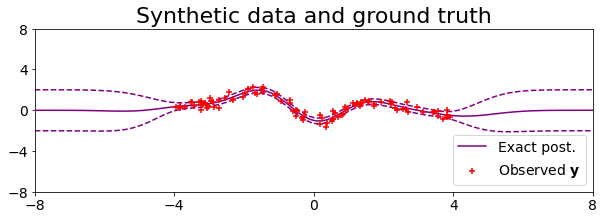

In [7]:
# Plot inducing points and observed data
plt.figure(figsize=(10, 3))
    
# Plot exact posterior predictive
plt.plot(x_plot, y_plot_mean - 2*y_plot_std, '--', color='purple',  zorder=2)
plt.plot(x_plot, y_plot_mean, color='purple',  zorder=2, label='Exact post.')
plt.plot(x_plot, y_plot_mean + 2*y_plot_std, '--', color='purple',  zorder=2)

# Plot sampled data
plt.scatter(x_train,
            y_train,
            color='red',
            marker='+',
            zorder=3,
            label=r'Observed $\mathbf{y}$')

# Plot formatting
plt.title('Synthetic data and ground truth', fontsize=22)
plt.xticks(np.arange(-8, 9, 4), fontsize=14)
plt.yticks(np.arange(-8, 9, 4), fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.xlim([-8., 8.])
plt.show()

In [8]:
def plot(model,
         ground_truth_cov,
         ground_truth_noise,
         x_pred,
         x_train,
         y_train,
         x_ind_init,
         step):

    # Get exact and approximate posterior predictive
    vfe_mean, vfe_cov = model.post_pred(x_pred)

    # Covariances between inducing points and input locations
    K_train_plot = ground_truth_cov(x_train, x_plot)
    K_plot_train = ground_truth_cov(x_plot, x_train)
    K_plot_diag = ground_truth_cov(x_plot, x_plot, diag=True)

    # Mean and standard deviation of y_plot | f_ind, x_plot
    exact_mean = np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise, y_train))[:, 0]
    exact_cov = K_plot_diag - np.dot(K_plot_train, np.linalg.solve(K_train_train + I_noise, K_train_plot))
    exact_var = np.diagonal(exact_cov)
    exact_std = (exact_var + ground_truth_noise ** 2) ** 0.5
    
    x_pred = x_pred[:, 0].numpy()
    x_ind = model.x_ind[:, 0].numpy()
    
    vfe_mean = vfe_mean.numpy()
    vfe_var = tf.linalg.diag_part(vfe_cov).numpy()
    
    plt.figure(figsize=(10, 3))
    
    # Plot posterior predictive
    plt.plot(x_pred,
             vfe_mean,
             color='black',
             zorder=1,
             label='Approx. Post.')
    
    print(vfe_mean.shape, vfe_var.shape, x_pred.shape)
    plt.fill_between(x_pred,
                     vfe_mean - 2 * vfe_var ** 0.5,
                     vfe_mean + 2 * vfe_var ** 0.5,
                     color='gray',
                     alpha=0.3)
    
    # Plot exact posterior
    plt.plot(x_plot,
             exact_mean - 2*exact_std,
             '--',
             color='purple',
             zorder=1)
    
    plt.plot(x_plot,
             exact_mean,
             color='purple',
             zorder=1)
    
    plt.plot(x_plot,
             exact_mean + 2*exact_std,
             '--',
             color='purple',
             zorder=1,
             label='Exact Post.')

    # Plot training data
    plt.scatter(x_train, y_train, color='red', marker='+', zorder=2)
    
    # Plot initial inducing points
    plt.scatter(x_ind_init,
                -5.5 * tf.ones_like(x_ind_init),
                color='green',
                marker='+',
                label=r'Init. $\bar{\mathbf{X}}$',
                zorder=2)
    
    # Plot current inducing points
    plt.scatter(x_ind,
                -5. * tf.ones_like(x_ind),
                color='blue',
                marker='+',
                label=r'Curr. $\bar{\mathbf{X}}$',
                zorder=2)
    
    # Format plot
    plt.title(f'VFE after {step} optimisation steps', fontsize=18)
    
    plt.xticks(np.arange(-10, 11, 4), fontsize=14)
    plt.yticks(np.arange(-6, 7, 3), fontsize=14)
    
    plt.xlim([-8., 8.])
    plt.ylim([-8., 4.])
    
    plt.legend(loc='lower right', fontsize=10)
    
    plt.show()
    
    
def print_info(model, step):
    
    free_energy = model.free_energy()
    
    print(f'Step: {step:5>} '
          f'Free energy: {free_energy.numpy():8.3f} '
          f'Coeff: {model.cov.coeff.numpy():5.2f} '
          f'Scales: {[round(num, 3) for num in model.cov.scales.numpy()]} '
          f'Noise: {model.noise.numpy():5.2f}')

Step: 0 Free energy:  -39.651 Coeff:  1.00 Scales: [1.0] Noise:  0.10
(100,) (100,) (100,)


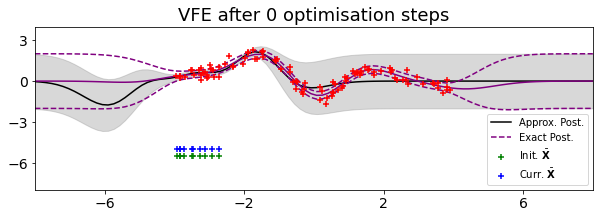

Step: 10 Free energy:   -3.673 Coeff:  0.48 Scales: [1.635] Noise:  0.23
(100,) (100,) (100,)


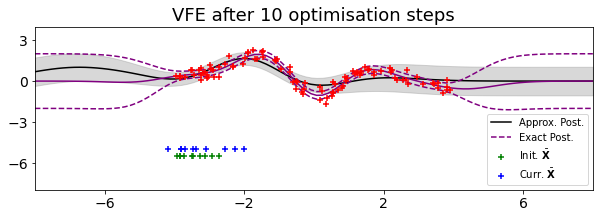

In [9]:
# Set random seed and tensor dtype
tf.random.set_seed(1)

# Number GP constants
M = 10
inducing_range = (-4., -2.)
log_noise = np.log(1e-1)
log_coeff = np.log(1e0)
log_scales = [np.log(1e0)]
ind_fraction = None
trainable_inducing = True
trainable_noise = True

# Define mean and covariance
mean = ConstantMean(dtype=dtype)

# Initialise covariance
cov = EQ(log_coeff=log_coeff,
         log_scales=log_scale,
         trainable=True,
         dtype=dtype)

# Initial locations of inducing points
x_ind_dist = tfp.distributions.Uniform(*inducing_range)
x_ind = x_ind_dist.sample(sample_shape=(M, 1))
x_ind = tf.cast(x_ind, dtype=dtype)

# Define sparse VFEGP
vfe_gp = VFEGP(mean=mean,
               cov=cov,
               x_train=x_train,
               y_train=y_train,
               x_ind=x_ind,
               ind_fraction=ind_fraction,
               trainable_inducing=trainable_inducing,
               log_noise=log_noise,
               trainable_noise=trainable_noise,
               dtype=dtype)

num_steps = 10
optimizer = tf.keras.optimizers.Adam(1e-1)

x_pred = tf.linspace(-8., 8., 100)[:, None]
x_pred = tf.cast(x_pred, dtype=dtype)

for step in range(num_steps + 1):
    
    with tf.GradientTape() as tape:

        free_energy = vfe_gp.free_energy()
        loss = - free_energy
        
        # Print information and plot at start and end
        if step % num_steps == 0:
            
            print_info(vfe_gp, step)

            plot(vfe_gp,
                 ground_truth_cov,
                 noise,
                 x_pred,
                 x_train,
                 y_train,
                 x_ind,
                 step)

    gradients = tape.gradient(loss, vfe_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp.trainable_variables))

In [10]:
environment = Environment(name='MountainCar', sub_sampling_factor=4)

environment.reset()

num_steps = 100

states = []
actions = []
next_states = []

for i in range(num_steps):
    
    s, a, s_ = environment.step(np.array([1.]))
    
    states.append(s)
    actions.append(a)
    next_states.append(s_)
    
states = np.array(states)
actions = np.array(actions)
next_states = np.array(next_states)

x_train = tf.convert_to_tensor(np.concatenate([states, actions], axis=1), dtype=tf.float64)
y_train = tf.convert_to_tensor(next_states[:, :1], dtype=tf.float64)

_ = check_shape([x_train, y_train], [('N', 3), ('N', 1)])

In [11]:
# Set random seed and tensor dtype
tf.random.set_seed(1)

# Number GP constants
log_noise = np.log(1e-1)
log_coeff = np.log(1e0)
log_scales = [np.log(1e0)]
ind_fraction = 0.5
x_ind = None
trainable_inducing = True
trainable_noise = True

# Define mean and covariance
mean = ConstantMean(dtype=dtype)

# Initialise covariance
cov = EQ(log_coeff=log_coeff,
         log_scales=log_scale,
         trainable=True,
         dtype=dtype)

# Define sparse VFEGP
vfe_gp = VFEGP(mean=mean,
               cov=cov,
               x_train=x_train,
               y_train=y_train,
               x_ind=x_ind,
               ind_fraction=ind_fraction,
               trainable_inducing=trainable_inducing,
               log_noise=log_noise,
               trainable_noise=trainable_noise,
               dtype=dtype)

num_steps = 10
optimizer = tf.keras.optimizers.Adam(1e-1)

for step in range(num_steps + 1):
    
    with tf.GradientTape() as tape:

        free_energy = vfe_gp.free_energy()
        loss = - free_energy
        
        # Print information and plot at start and end
        if step % num_steps == 0:
            
            print_info(vfe_gp, step)

    gradients = tape.gradient(loss, vfe_gp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp.trainable_variables))

Step: 0 Free energy:    1.044 Coeff:  1.00 Scales: [1.0] Noise:  0.10
Step: 10 Free energy:    2.079 Coeff:  2.60 Scales: [2.072] Noise:  0.04


In [12]:
environment = Environment(name='MountainCar', sub_sampling_factor=4)

environment.reset()

num_steps = 100

states = []
actions = []
next_states = []

for i in range(num_steps):
    
    s, a, s_ = environment.step(2. * np.random.rand(1) - 1.)
    
    states.append(s)
    actions.append(a)
    next_states.append(s_)
    
states = np.array(states)
actions = np.array(actions)
next_states = np.array(next_states)

x_train = tf.convert_to_tensor(np.concatenate([states, actions], axis=1), dtype=tf.float64)
y_train = tf.convert_to_tensor(next_states, dtype=tf.float64)

_ = check_shape([x_train, y_train], [('N', 3), ('N', 2)])

In [13]:
# State and action dimensions
sdim = 2
adim = 1
dtype = tf.float64

# Number GP constants
log_noise = np.log(1e-1)
log_coeff = np.log(1e0)
log_scales = [np.log(1e0)] * (sdim + adim)
ind_fraction = 0.5
x_ind = None
trainable_inducing = False
trainable_covariance = False
trainable_noise = True

# Define mean and covariance
means = [ConstantMean(dtype=dtype) for i in range(sdim+adim)]

# Initialise covariance
covs = [EQ(log_coeff=log_coeff,
           log_scales=log_scales,
           trainable=trainable_covariance,
           dtype=dtype) for i in range(sdim)]

# Define sparse VFEGP
vfe_gps = [VFEGP(mean=means[i],
                 cov=covs[i],
                 x_train=x_train,
                 y_train=y_train[:, i:i+1],
                 x_ind=x_ind,
                 ind_fraction=ind_fraction,
                 trainable_inducing=trainable_inducing,
                 log_noise=log_noise,
                 trainable_noise=trainable_noise,
                 dtype=dtype) for i in range(sdim)]

vfe_gp_stack = VFEGPStack(vfe_gps, dtype=dtype)

num_steps = 100
optimizer = tf.keras.optimizers.Adam(1e-2)

for step in range(num_steps + 1):
    
    with tf.GradientTape() as tape:

        free_energy = vfe_gp_stack.free_energy()
        loss = - free_energy
        
        # Print information and plot at start and end
        if step % num_steps == 0:
            
            print_info(vfe_gp_stack.vfe_gps[0], step)
            print_info(vfe_gp_stack.vfe_gps[1], step)

    gradients = tape.gradient(loss, vfe_gp_stack.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vfe_gp_stack.trainable_variables))

Step: 0 Free energy:    0.795 Coeff:  1.00 Scales: [1.0, 1.0, 1.0] Noise:  0.10
Step: 0 Free energy:    0.981 Coeff:  1.00 Scales: [1.0, 1.0, 1.0] Noise:  0.10
Step: 100 Free energy:    1.284 Coeff:  1.00 Scales: [1.0, 1.0, 1.0] Noise:  0.04
Step: 100 Free energy:    1.675 Coeff:  1.00 Scales: [1.0, 1.0, 1.0] Noise:  0.04


In [14]:
vfe_gp_stack.vfe_gps[0].noise, vfe_gp_stack.vfe_gps[0].cov.scales

(<tf.Tensor: shape=(), dtype=float64, numpy=0.04074170641670296>,
 <tf.Tensor: shape=(3,), dtype=float64, numpy=array([1., 1., 1.])>)

In [15]:
vfe_gp_stack.vfe_gps[1].noise, vfe_gp_stack.vfe_gps[1].cov.scales

(<tf.Tensor: shape=(), dtype=float64, numpy=0.037690717517156885>,
 <tf.Tensor: shape=(3,), dtype=float64, numpy=array([1., 1., 1.])>)

In [17]:
num_features = 20

post_sample = vfe_gp_stack.sample_posterior(num_features=num_features)

In [19]:
post_sample(tf.convert_to_tensor([[1., 1., 0.]], dtype=tf.float64), add_noise=False)

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[1.32197557, 0.38253406]])>